# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
Description: Process xdf files recorded from experimental sessions to determine file eligibility and data feature extraction.<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp


## Imports

In [49]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import *

# import copy
## import time
# import pyeeg
#from neurodsp.plts.spectral import *
# import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def findLargestStdev(component, verbose=True):
    max_i = 0
    max_val = 0
    for i in range(4): 
        filtered_sig = filterEEG(component[:,i], eeg_fs, (1, 5))
        std_val = np.std(filtered_sig)
        if (verbose) :
            plt.plot(filtered_sig, label=str(i) + " " + str(std_val))
        if std_val > max_val : 
            max_i = i
            max_val = std_val
    
    if (verbose) :
        plt.legend()
        plt.title("filtered signals to find blinks")
        plt.show()
    return max_i

In [ ]:
def getCleanedSignal(original_data, verbose=True):
    active_eeg = original_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())]
    eeg_time = original_data[StreamType.EEG.value][StreamType.TIME.value]

    if(verbose) : 
        line_objects = plt.plot(eeg_time, active_eeg)
        plt.legend(iter(line_objects), list(channels.keys()))
        plt.title("EEG of 2 Eye Blinks")
        plt.show()

    ica = FastICA(n_components=4)
    standardized=active_eeg
    standardized /= active_eeg.std(axis=0)
    
    S = ica.fit_transform(active_eeg)  # Reconstruct signals
    
    if(verbose):
        line_objects = plt.plot(eeg_time, S)
        plt.legend(iter(line_objects), list(range(len(line_objects))))
        plt.title("ICA Decomposition of EEG")
        plt.show()

    # Get the component with the largest standard deviation after being filtered to 1-10Hz
    max_i = findLargestStdev(S, verbose=verbose)
    
    remove_indices = [max_i]  # pretend the user selected components 0, 1, and 3
    
    cleaned_components = copy.deepcopy(S)
    # "remove" unwanted components by setting them to 0 - simplistic but gets the job done
    cleaned_components[:, remove_indices] = 0
    
    #reconstruct signal
    X_restored = ica.inverse_transform(cleaned_components)
    
    filtered_cleaned_data = copy.deepcopy(original_data)
    i = 0
    for channel in channels: 
        filtered_cleaned_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] = X_restored[:,i]
        i += 1
        
    if(verbose):
        line_objects = plt.plot(eeg_time, X_restored)
        plt.legend(iter(line_objects), list(channels.keys()))
        plt.title("EEG without blinks")
        plt.show()
    
    return filtered_cleaned_data
    

In [ ]:
def filterStreamStructEEG(original_data):
    filtered_data = copy.deepcopy(original_data)
    for channel in channels :
        eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
        sig_filt = filterEEG(eeg_data, eeg_fs)
        filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] = sig_filt

    return filtered_data

In [ ]:
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [ ]:
def plotPowerRatio(power_ratio, intervals): 
    y_pos = list(range(len(power_ratio)))
    plt.bar(y_pos, power_ratio, align='center', alpha=0.5)
    plt.xticks(y_pos, intervals)
    plt.ylabel('Power Ratio')
    plt.xlabel('Hz')
    plt.title('Power ratio of each frequency bin')
    plt.show()

In [ ]:
def getPowerRatio(eeg_data, binning):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)

In [ ]:
def signalNoisy(eeg_signal, noise_threshold=12, verbose=True): 
    filtered_sig = filterEEG(eeg_signal, eeg_fs, (1, 5))
    std_val = np.std(filtered_sig)
    if(verbose) :
        plt.plot(filtered_sig, label=str(std_val))
        plt.title("Std of signals. Those with std >"+str(noise_threshold)+" will not be included in average")
    if(std_val < noise_threshold):
        return False
    else:
        return True

In [ ]:
def getLeftRightEEG(list_epochs, epoch_length=700, **kwargs):
    left_data_list = list()
    right_data_list = list() 
    
    for data in list_epochs: 
        left_data = data[StreamType.EEG.value][StreamType.DATA.value][:,channels["left_eeg"]][:epoch_length]
        right_data = data[StreamType.EEG.value][StreamType.DATA.value][:,channels["right_eeg"]][:epoch_length]
        
        if(not signalNoisy(left_data, **kwargs)) :
            left_data_list.append(left_data)
        if(not signalNoisy(right_data, **kwargs)) :
            right_data_list.append(right_data) 
    return left_data_list, right_data_list     

In [ ]:
def getLeftRightData(list_epochs, **kwargs):
    # Returns left_average, right_average data of the list epochs
    
    left_data_list, right_data_list = getLeftRightEEG(list_epochs, **kwargs) 
    
    average_left_data = np.mean(left_data_list, axis=0)
    average_right_data = np.mean(right_data_list, axis=0)
    
    power_ratio_left = [getPowerRatio(data, binning) for data in left_data_list]
    power_ratio_right = [getPowerRatio(data, binning) for data in right_data_list]
    
    return (left_data_list, right_data_list), (average_left_data, average_right_data), (power_ratio_left, power_ratio_right)

In [ ]:
# def transposeLists(original): 
#     transposed = np.transpose(original)
#     lists = list() 
#     for i in transposed : 
#         lists.append(i)
#     return lists

In [ ]:
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None): 
    if len(bar_names) != len(bars):
        print("group names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])

    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()


In [ ]:
def getWindows(eeg_data, fs=250, shift_length=50, window_length=1.0) : 
    # eeg_data = voltages
    # fs = sampling rate of eeg_data
    # shift_length = shift by 5 samples for each window
    # window_length = 1 second
    
    cursor = 0
    windows = list() 
    while(len(eeg_data) - cursor - int(eeg_fs * window_length) > 0):
        windows.append(eeg_data[cursor:cursor + int(eeg_fs * window_length)])
        cursor += shift_length
    return windows

In [ ]:
def getWindowsList(df, **kwargs) : 
    windows = list() 

    if (type(df) == list) :
        print("getWindows on list!")
        # Directly use the list as the list of EEG to get windows for
        flattened_data_list = df
        for eeg_data in flattened_data_list :
            windows.extend(getWindows(eeg_data, **kwargs))
        
    if (type(df) == tuple) :
        print("getWindows on tuple!")
        # Unwrap the tuples to allow for each element to be an EEG in the list to windows for 
        flattened_data_list = [item for sublist in df for item in sublist]
        for eeg_data in flattened_data_list :
            windows.extend(getWindows(eeg_data, **kwargs))
        
    if (type(df) == pd.DataFrame) : 
        print("getWindows on Dataframe! ")
        # Get each data and each right and left eeg to window
        for i, row in df.iterrows():
            data = row["data"]
            windows.extend(getWindows(data[StreamType.EEG.value][StreamType.DATA.value][:, channels['right_eeg']], **kwargs))
            windows.extend(getWindows(data[StreamType.EEG.value][StreamType.DATA.value][:, channels['left_eeg']], **kwargs))
    return np.array(windows)

In [ ]:
def getFreqsAndPSD(data_list, eeg_fs=250) :
    # Gets the frequencies and psds of the data list 
    freq_to_return = 0
    psd_list_to_return = list()
    if(type(data_list) == tuple) :
        #print("tuple!")
        flattened_data_list = [item for sublist in data_list for item in sublist]
    else :
        #print("not tuple?")
        flattened_data_list = data_list
    for i in range(len(flattened_data_list)): 
        #print(flattened_data_list[i])
        freq, psd = spectral.compute_spectrum(flattened_data_list[i], eeg_fs, method='welch', avg_type='median', nperseg=eeg_fs*2)
        freq_to_return = freq
        psd_list_to_return.append(psd)
    
    psd_avg = np.mean(psd_list_to_return, axis=0)
    
    return freq_to_return, psd_list_to_return, psd_avg

In [ ]:
def getSEM(numbers) :
    return (np.std(numbers, axis=0) * 2) / np.sqrt(len(numbers))

## Main

### Get Data

In [3]:
'''
Files that work with this notebook: 
participant_P004_exp001_block_full_start.xdf # full start
participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
participant_P004_exp003_block_full_start.xdf # This should work too
participant_P004_exp001_block_full_short.xdf # Works
participant_P004_exp001_block_full_long.xdf # Works

participant_P001_exp001_block_full_long.xdf # Me, very sleepy. 

'''

XDF_Data = loadxdf("../data/P004/participant_P004_exp001_block_full_long.xdf")
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
if StreamType.EYE.value in XDF_Data : 
    time_differences_eye_tracker = [XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
    mean_fs_eye_tracker = 1/np.mean(time_differences_eye_tracker)
    eye_fs = int(mean_fs_eye_tracker)
    print("eye_fs = ", eye_fs)
# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

markers = np.array(XDF_Data[MARKER_STREAM_TYPE][DATA_STREAM_TYPE][:,0])
marker_indexes = {}
for index, marker in enumerate(markers): 
    marker_indexes[marker] = index
    


eeg_fs =  250
eye_fs =  37


In [4]:
# Recording data checks (whether all markers are there etc)
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in markers: 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)


Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --LettersShown
All Markers Found? False


## Filtering

### Filter 1-50 Hz

In [5]:
filtered_data = filterStreamStructEEG(XDF_Data)

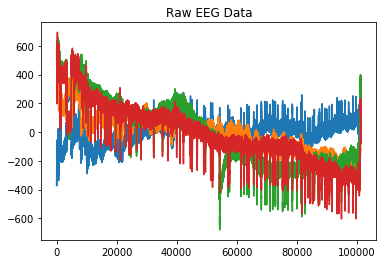

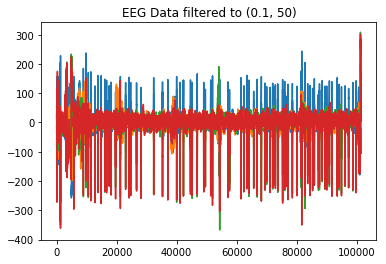

In [6]:
# Check filtering
for channel in channels: 
    eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("Raw EEG Data")
plt.show()

for channel in channels: 
    eeg_data = filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("EEG Data filtered to " + str(f_range))
margin =  800 #len(freq) // 2 means all. 600 to see 60Hz
plt.show()

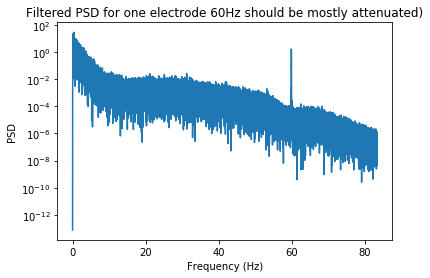

In [7]:
freq, psd = signal.periodogram(filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels["right_eeg"]], fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD') # not sure what the unit is...
plt.title('Filtered PSD for one electrode 60Hz should be mostly attenuated)')
plt.semilogy(freq[: int(len(freq) / 1.5)], psd[: int(len(freq) / 1.5)])
plt.show()


## Clean artifacts from VEOG

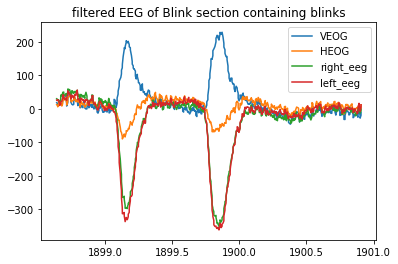

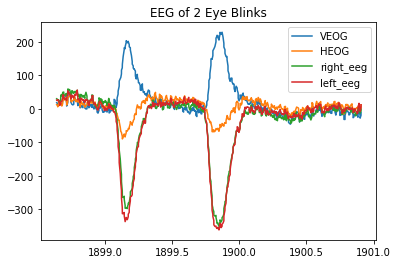

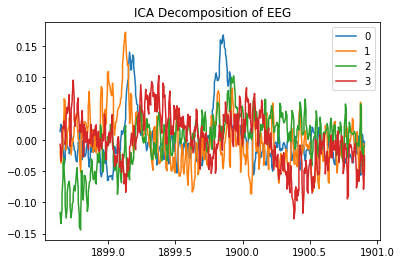

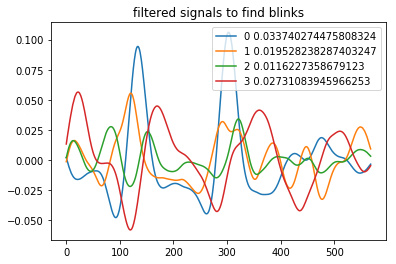

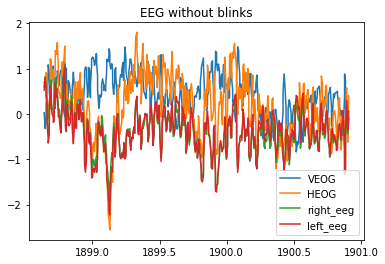

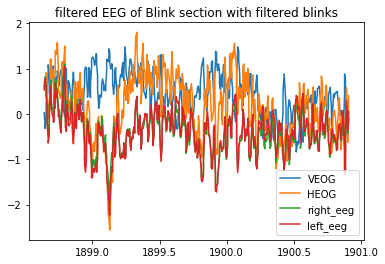

In [8]:
# Filter only the blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

# Show original blink data
line_objects = plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section containing blinks")
plt.show()

# Filter out the blink component
filtered_cleaned_blink_data  = getCleanedSignal(blink_data, verbose=True)

# Show the data without the blink component
plt.plot(filtered_cleaned_blink_data[StreamType.EEG.value][StreamType.TIME.value], filtered_cleaned_blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()



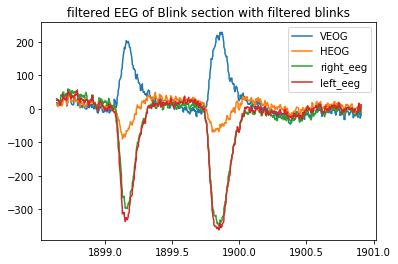

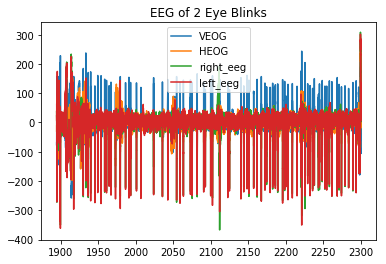

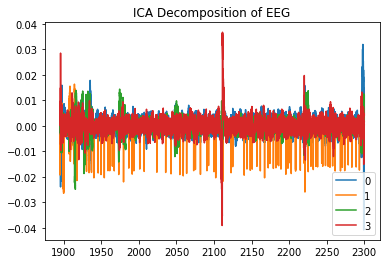

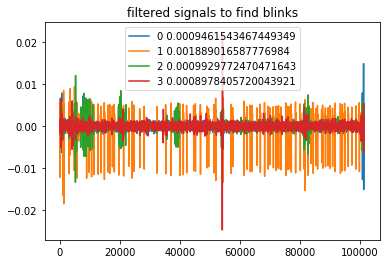

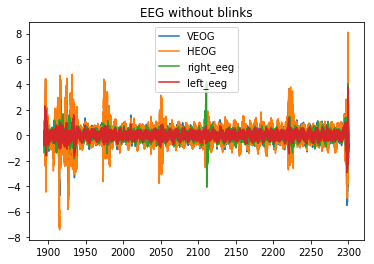

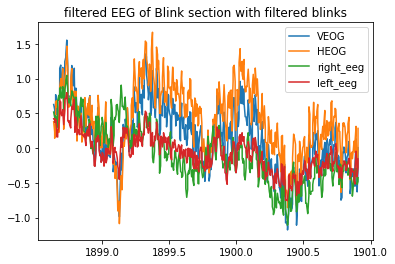

In [9]:
#Filter the entire EEG data

# Show original blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()

#Filter the entire EEG data
filtered_cleaned_data  = getCleanedSignal(filtered_data, verbose=True)


# Show the cleaned data at the blink section
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_cleaned_data)
blink_data = new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()


## Get points for each section

In [10]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_cleaned_data))


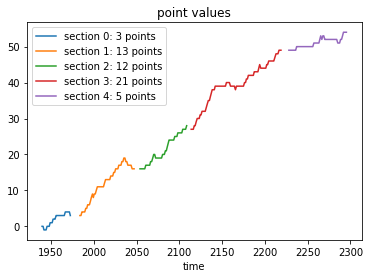

In [11]:
for i, article_section in enumerate(article_sections):
    data, time = getPointsAfterEachWord(article_section)
    num_delta_points = getTotalPoints(article_section)
    plt.plot(time[:], data[:], label="section " + str(i) + ": " + str(num_delta_points) + " points")
plt.title("point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Get power for each section

In [12]:
binning=list(np.arange(.5, 30, 2))
intervals = getIntervals(binning)

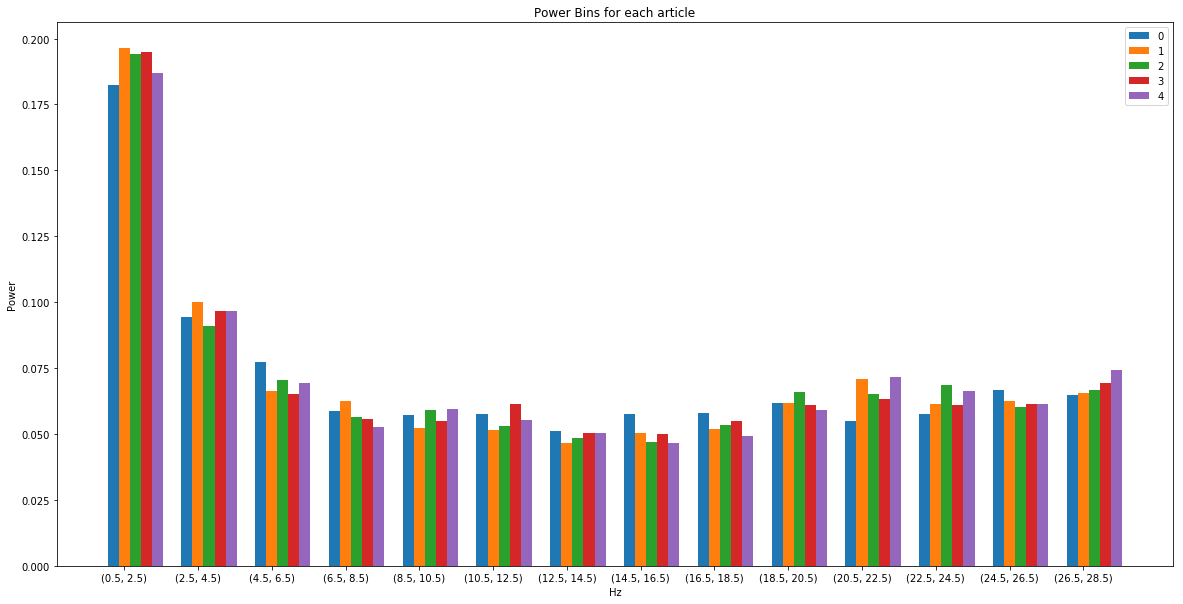

In [13]:
power_ratios = list()
for article_section in article_sections: 
    power_ratio = getPowerRatio(article_section[StreamType.EEG.value][StreamType.DATA.value][:,channels['right_eeg']], binning)
    power_ratios.append(power_ratio)

plt.figure(figsize=(20,10))
plotMultipleBarGraphs(power_ratios, 0.15, list(range(len(article_sections))), intervals, title="Power Bins for each article", xlabel="Hz", ylabel="Power")



## Epoch into Neg, Neutral, Pos

In [14]:
# Determine the time frames in which the memes are shown
meme_is_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
meme_eeg_data, meme_averages, meme_power_ratio = getLeftRightData(meme_is_shown_data, binning, verbose=False)
meme_shown_times = list() 
for data in meme_is_shown_data:
    start_time = data[StreamType.EEG.value][StreamType.TIME.value][0]
    end_time = data[StreamType.EEG.value][StreamType.TIME.value][-1]
    meme_shown_times.append((start_time, end_time))

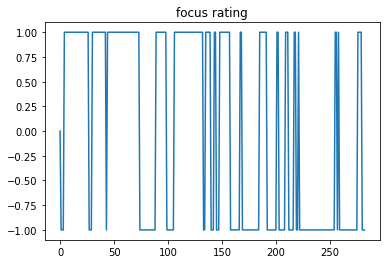

num neg: 138 num neu: 1 num pos: 144


In [15]:
## Categorize word data into "distracted" "neutral" and "focus" states. 
# "distracted" = negative value points 
# "neutral" = 0 value points
# "positive" = positive value points
# value points are based on the original point attainments, but with distractors included
include_distractors = True

new_word_data, a, b = getTimeBoundSingleLabelData("newWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
points = [getTotalPoints(data) for data in new_word_data] 

# Calculate the distraction level
new_points = []
has_memes = []
for i, point in enumerate(points):
    if(include_distractors) : 
        original_point = point
        # If meme is shown at the moment, subtract 1 point
        start_time = new_word_data[i][StreamType.EEG.value][StreamType.TIME.value][0]
        end_time = new_word_data[i][StreamType.EEG.value][StreamType.TIME.value][1]
        has_meme = False
        for meme_shown_interval in meme_shown_times: 
            if end_time > meme_shown_interval[0] and end_time < meme_shown_interval[1] :
                has_meme = True
        if has_meme: 
            point -= 1
            
        # If meme begins to show during this word, subtract another point
        data_markers = new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value]
        if getLabelMarkerString("memeShown") in data_markers: 
            point -= 1
            
        has_memes.append(has_meme)

        # If lettersShown, subtract 1 point and also decrement the previous value. 
        if getLabelMarkerString("lettersShown") in data_markers: 
            point -= 1
            new_points[-1] -= 1
        
        if i > 0:
            if original_point > 0 and points[i-1] >= 0: 
                new_points[-1] += 1
            if original_point < 0 and points[i-1] <= 0: 
                new_points[-1] += -1
    new_points.append(point)

    
# Floor and Ceiling   
for i in range(len(new_points)): 
    if new_points[i] > 0: 
        new_points[i] = 1
    elif new_points[i] < 0: 
        new_points[i] = -1
    else :
        new_points[i] = 0
        
# Average 
for i in range(1, len(new_points)): 
    new_points[i] = (new_points[i-1] + new_points[i]) / 2

    
# Floor and Ceiling   
for i in range(len(new_points)): 
    if new_points[i] > 0: 
        new_points[i] = 1
    elif new_points[i] < 0: 
        new_points[i] = -1
    else :
        new_points[i] = 0
    
# Display focus points 
plt.plot(new_points)
plt.title("focus rating")
plt.show()


# Construct the lists of data
neg_points_data = []
pos_points_data = []
neu_points_data = []
for i, point in enumerate(new_points): 
    if point < 0: 
        neg_points_data.append(new_word_data[i])
    elif point == 0: 
        neu_points_data.append(new_word_data[i])
    else : 
        pos_points_data.append(new_word_data[i])
neg_eeg_data, neg_averages, neg_power_ratio = getLeftRightData(neg_points_data, binning, epoch_length=499, verbose=False)
neu_eeg_data, neu_averages, neu_power_ratio = getLeftRightData(neu_points_data, binning, epoch_length=499, verbose=False)
pos_eeg_data, pos_averages, pos_power_ratio = getLeftRightData(pos_points_data, binning, epoch_length=499, verbose=False)

print("num neg:", len(neg_eeg_data[0]), "num neu:", len(neu_eeg_data[0]), "num pos:", len(pos_eeg_data[0]))
neg_power_ratio_avg = np.mean(neg_power_ratio[0] + neg_power_ratio[1], axis=0)
neu_power_ratio_avg = np.mean(neu_power_ratio[0] + neu_power_ratio[1], axis=0)
pos_power_ratio_avg = np.mean(pos_power_ratio[0] + pos_power_ratio[1], axis=0)


### Plot ERP

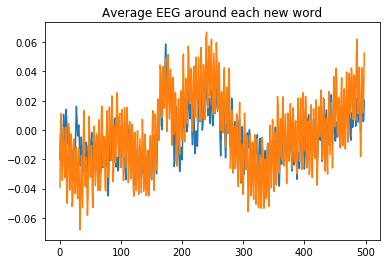

In [16]:
# Plot ERPs around new word for distraction vs focus
plt.plot(np.mean(neg_eeg_data[0][:] + neg_eeg_data[1][:], axis=0), label="distraction")
#plt.plot(np.mean(neu_eeg_data[0] + neu_eeg_data[1], axis=0))
plt.plot(np.mean(pos_eeg_data[0][:] + pos_eeg_data[1][:], axis=0), label="focus")

plt.title("Average EEG around each new word")
plt.show()

### Spectral analysis of new word epochs

In [17]:
# standard error bars
# Reaction time
# balance the difficulty by looking at the results of the previous section
# flash memes

- [ ] standard error bars
- [X] standard error bars

In [18]:
# Calculate PSDs (can replace with getFreqsAndPSD)
neg_freqs = list()
neu_freqs = list()
pos_freqs = list()
neg_psd = list()
neu_psd = list()
pos_psd = list()

for i in [0,1]: 
    for j in range(len(neg_eeg_data[0])): 
        neg_freq_med, neg_psd_med = spectral.compute_spectrum(neg_eeg_data[i][j], eeg_fs, method='welch', avg_type='median', nperseg=eeg_fs/4)
        neg_freqs = neg_freq_med
        neg_psd.append(neg_psd_med)
        
    for j in range(len(neu_eeg_data[0])) :
        neu_freq_med, neu_psd_med = spectral.compute_spectrum(neu_eeg_data[i][j], eeg_fs, method='welch', avg_type='median', nperseg=eeg_fs/4)
        neu_freqs = neu_freq_med 
        neu_psd.append(neu_psd_med)
        
    for j in range(len(pos_eeg_data[0])) :
        pos_freq_med, pos_psd_med = spectral.compute_spectrum(pos_eeg_data[i][j], eeg_fs, method='welch', avg_type='median', nperseg=eeg_fs/4)
        pos_freqs = pos_freq_med
        pos_psd.append(pos_psd_med)
        

neg_psd_avg = np.mean(neg_psd, axis=0)
neu_psd_avg = np.mean(neu_psd, axis=0)
pos_psd_avg = np.mean(pos_psd, axis=0)

neg_sem = getSEM(np.array(neg_power_ratio[0] + neg_power_ratio[1]))
neu_sem = getSEM(np.array(neu_power_ratio[0] + neu_power_ratio[1]))
pos_sem = getSEM(np.array(pos_power_ratio[0] + pos_power_ratio[1]))

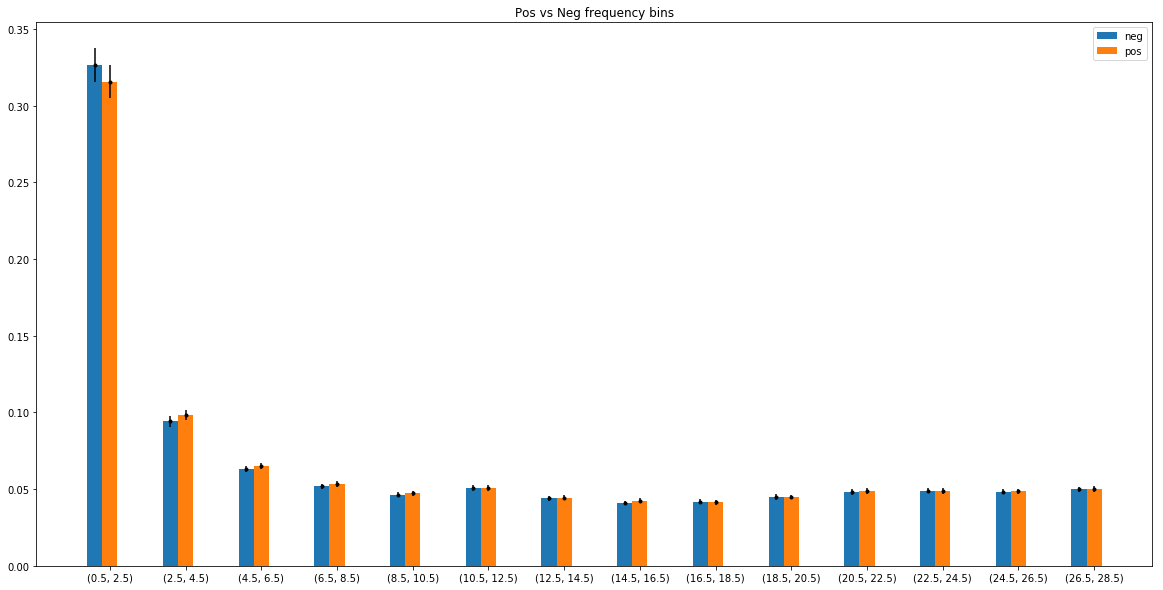

In [19]:
plt.figure(figsize=(20,10))
plt.title("Pos vs Neg frequency bins")
plotMultipleBarGraphs([neg_power_ratio_avg, pos_power_ratio_avg], 0.2, ["neg", "pos"], intervals, error_values=[neg_sem, pos_sem])

neg 276 pos 32


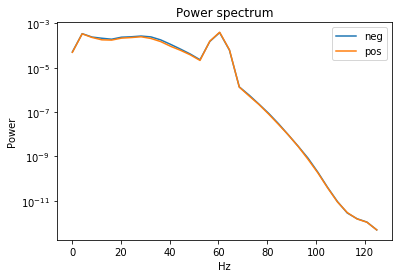

In [20]:
plot_window_size = 150
print("neg", len(neg_psd), "pos", len(pos_freqs))


plt.plot(neg_freqs[:plot_window_size], neg_psd_avg[:plot_window_size], label="neg")
plt.semilogy(pos_freqs[:plot_window_size], pos_psd_avg[:plot_window_size], label="pos")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

## Analysis before and after meme show

In [21]:
meme_shown_data, a, b = getTimeBoundSingleLabelData("memeShown", filtered_cleaned_data, time_before=0, time_after=3)

meme_eeg_data, meme_averages, meme_power_ratio = getLeftRightData(meme_shown_data, binning, verbose=False)

meme_windows = getWindowsList(meme_eeg_data)
meme_freqs, meme_psds, meme_psd_avg = getFreqsAndPSD(meme_windows) 
meme_power_ratio_avg = np.mean(meme_power_ratio[0] + meme_power_ratio[1], axis=0)

meme_sem = getSEM(meme_power_ratio[0] + meme_power_ratio[1])



In [22]:
before_meme_shown_data, a, b = getTimeBoundSingleLabelData("memeShown", filtered_cleaned_data, time_before=3, time_after=0)

before_meme_eeg_data, before_averages, before_power_ratio = getLeftRightData(before_meme_shown_data, binning, verbose=False)
before_meme_windows = getWindowsList(before_meme_eeg_data)

before_meme_freqs, before_meme_psds, before_meme_psd_avg = getFreqsAndPSD(before_meme_windows) 
before_power_ratio_avg = np.mean(before_power_ratio[0] + before_power_ratio[1], axis=0)

before_meme_sem = getSEM(before_power_ratio[0] + before_power_ratio[1])


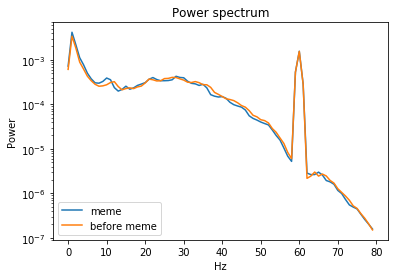

In [23]:
plot_window_size = 80

plt.semilogy(meme_freqs[:plot_window_size], meme_psd_avg[:plot_window_size], label="meme")
plt.semilogy(before_meme_freqs[:plot_window_size], before_meme_psd_avg[:plot_window_size], label="before meme")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

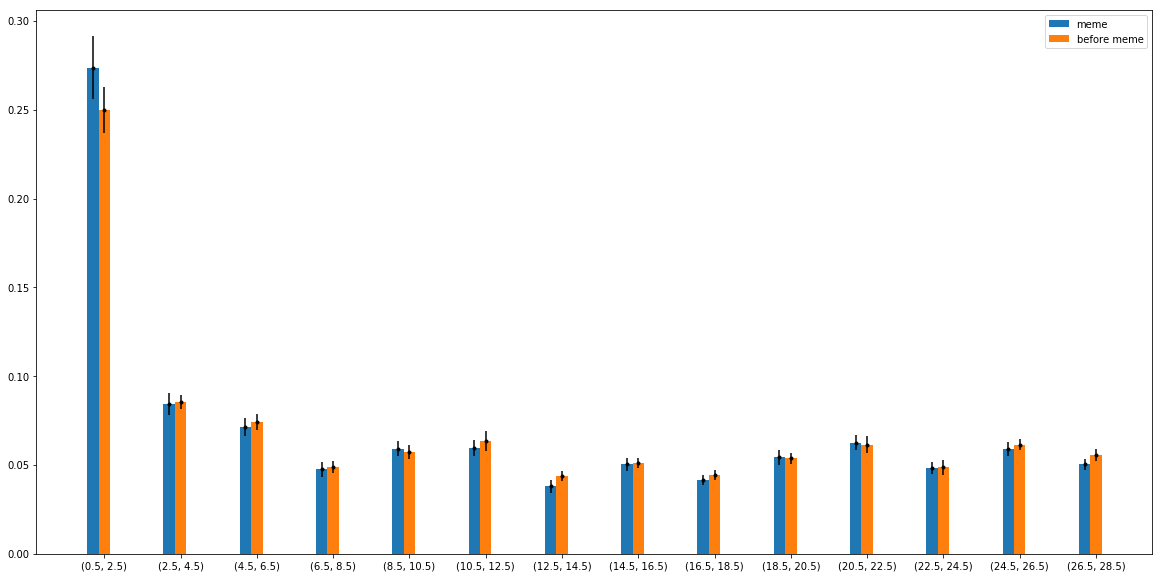

In [24]:
plt.figure(figsize=(20,10))

plotMultipleBarGraphs([meme_power_ratio_avg, before_power_ratio_avg], 0.15, ["meme", "before meme"], intervals, error_values=[meme_sem, before_meme_sem])

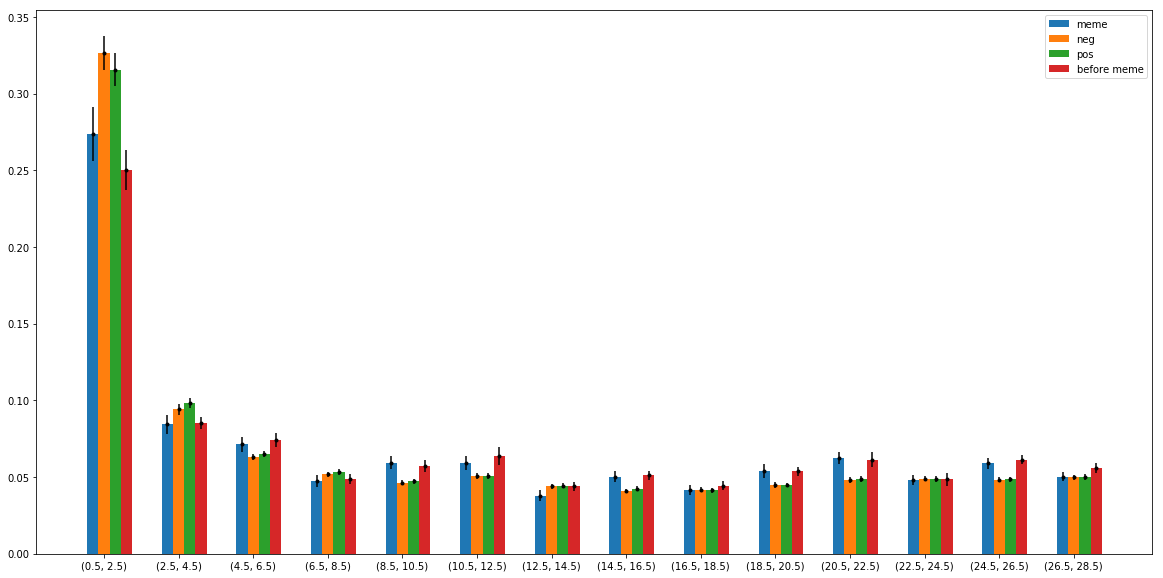

In [25]:
plt.figure(figsize=(20,10))

plotMultipleBarGraphs([meme_power_ratio_avg, neg_power_ratio_avg, pos_power_ratio_avg, before_power_ratio_avg], 0.15, ["meme","neg", "pos", "before meme"], intervals, error_values=[meme_sem, neg_sem, pos_sem, before_meme_sem])

## Finer Epoching
Target vs Nontarget <br> 
SpacePressed vs NoSpacePressed <br> 
Meme vs No Meme

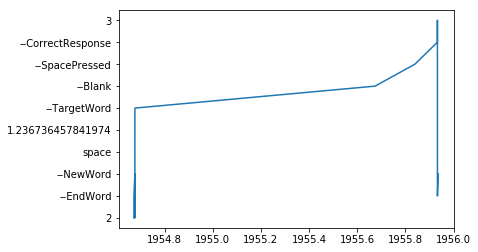

In [26]:
plt.plot(XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][197:210], markers[197:210])

In [27]:
# Construct data frame 
new_word_data, a, t_data = getTimeBoundSingleLabelData("newWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
points = [getTotalPoints(data) for data in new_word_data] 

data_info = dict() 
data_info["data_index"] = list() 
data_info["data"] = list() 
data_info["is_target"] = list() 
data_info["is_pressed"] = list() 
data_info["has_meme"] = list() 
data_info["time"] = list() 
data_info["points"] = list() 

start_marker_string = getLabelMarkerString("newWord")
end_marker_string = getLabelMarkerString("endWord")
target_word_string = getSingleLabelMarkerString("targetWord")
space_pressed_string = getSingleLabelMarkerString("spacePressed")
end_times = list()
for i, point in enumerate(points):
    
    # Find this word's start and end indexes 
    marker_indexes = getMarkerIndexes(new_word_data[i])
    start_word_index = marker_indexes[start_marker_string][0]
    end_word_index = marker_indexes[end_marker_string][-1]
    end_time = float(new_word_data[i][StreamType.MARKER.value][StreamType.TIME.value][end_word_index])
    end_times.append(end_time)
    # Determine if meme was shown
    has_meme = False
    for meme_shown_interval in meme_shown_times: 
        if (end_time > meme_shown_interval[0] and end_time < meme_shown_interval[1]) :
            has_meme = True
            break

    
    # Determine if word is a target word
    is_target = False
    if target_word_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_target = True
    
    # Determine if word was pressed on 
    is_pressed = False
    if space_pressed_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_pressed = True
    
    
    data_info["data_index"].append(i)
    data_info["data"].append(new_word_data[i])
    data_info["is_target"].append(is_target)
    data_info["is_pressed"].append(is_pressed)
    data_info["has_meme"].append(has_meme)
    data_info["time"].append(t_data[i])
    data_info["points"].append(point)

df = pd.DataFrame.from_dict(data_info)

In [28]:
unfocused_df = df[((df["is_pressed"] == False) & (df["is_target"] == True))]
unfocused_data = unfocused_df["data"].values
unfocused_windows = getWindowsList(unfocused_df)
unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(unfocused_windows) 
unfocused_power_ratio = [getPowerRatio(data[:499], binning) for data in unfocused_windows]

unfocused_sem = getSEM(unfocused_power_ratio)
unfocused_power_ratio_avg = np.mean(unfocused_power_ratio, axis=0)



focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True))]
focused_data = focused_df["data"].values
focused_windows = getWindowsList(focused_df)
focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(focused_windows) 
focused_power_ratio = [getPowerRatio(data[:499], binning) for data in focused_windows]

focused_sem = getSEM(focused_power_ratio)
focused_power_ratio_avg = np.mean(focused_power_ratio, axis=0)


super_focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True) & (df["has_meme"] == True))]
super_focused_data = super_focused_df["data"].values
super_focused_windows = getWindowsList(super_focused_df)
super_focused_freqs, super_focused_psds, super_focused_psd_avg = getFreqsAndPSD(super_focused_windows) 
super_focused_power_ratio = [getPowerRatio(data[:499], binning) for data in super_focused_windows]

super_focused_sem = getSEM(super_focused_power_ratio)
super_focused_power_ratio_avg = np.mean(super_focused_power_ratio, axis=0)


super_unfocused_df = df[((df["is_pressed"] == False) & (df["is_target"] == True) & (df["has_meme"] == True))]
super_unfocused_data = super_unfocused_df["data"].values
super_unfocused_windows = getWindowsList(super_unfocused_df)
super_unfocused_freqs, super_unfocused_psds, super_unfocused_psd_avg = getFreqsAndPSD(super_unfocused_windows) 
super_unfocused_power_ratio = [getPowerRatio(data[:499], binning) for data in super_unfocused_windows]

super_unfocused_sem = getSEM(super_unfocused_power_ratio)
super_unfocused_power_ratio_avg = np.mean(super_unfocused_power_ratio, axis=0)


mispress_df = df[((df["is_pressed"] == True) & (df["is_target"] == False))]
mispress_data = mispress_df["data"].values
mispress_windows = getWindowsList(mispress_df)
mispress_freqs, mispress_psds, mispress_psd_avg = getFreqsAndPSD(mispress_windows) 
mispress_power_ratio = [getPowerRatio(data[:499], binning) for data in mispress_windows]

mispress_sem = getSEM(mispress_power_ratio)
mispress_power_ratio_avg = np.mean(mispress_power_ratio, axis=0)


In [29]:
unfocused_windows[0].shape

(250,)

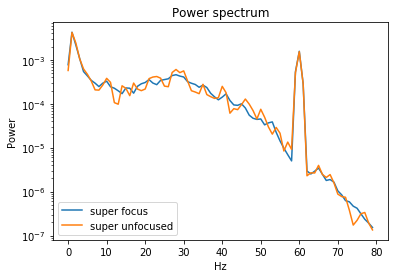

In [30]:
plt.semilogy(super_focused_freqs[:plot_window_size], super_focused_psd_avg[:plot_window_size], label="super focus")
plt.semilogy(super_unfocused_freqs[:plot_window_size], super_unfocused_psd_avg[:plot_window_size], label="super unfocused")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

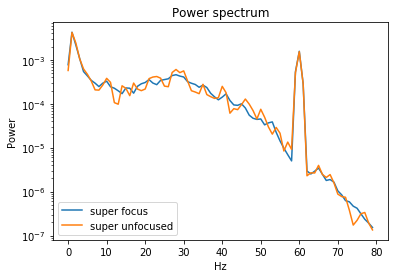

In [31]:
plt.semilogy(super_focused_freqs[:plot_window_size], super_focused_psd_avg[:plot_window_size], label="super focus")
plt.semilogy(super_unfocused_freqs[:plot_window_size], super_unfocused_psd_avg[:plot_window_size], label="super unfocused")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

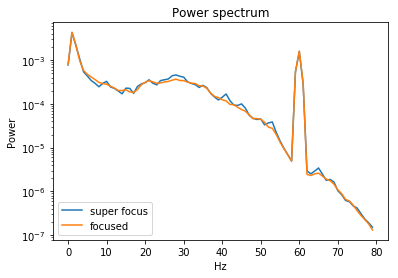

In [32]:
plt.semilogy(super_focused_freqs[:plot_window_size], super_focused_psd_avg[:plot_window_size], label="super focus")
plt.semilogy(focused_freqs[:plot_window_size], focused_psd_avg[:plot_window_size], label="focused")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

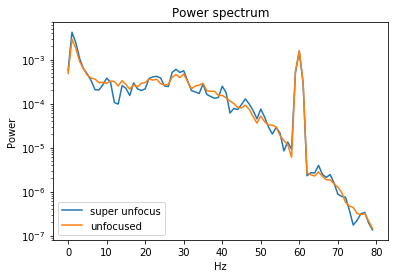

In [33]:
plt.semilogy(super_unfocused_freqs[:plot_window_size], super_unfocused_psd_avg[:plot_window_size], label="super unfocus")
plt.semilogy(unfocused_freqs[:plot_window_size], unfocused_psd_avg[:plot_window_size], label="unfocused")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

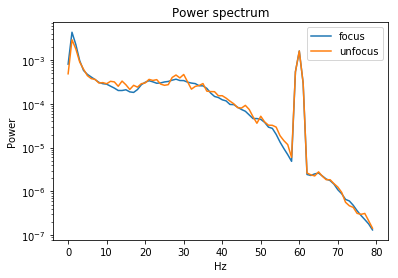

In [34]:
plt.semilogy(focused_freqs[:plot_window_size], focused_psd_avg[:plot_window_size], label="focus")
plt.semilogy(unfocused_freqs[:plot_window_size], unfocused_psd_avg[:plot_window_size], label="unfocus")
plt.legend()
plt.title("Power spectrum")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

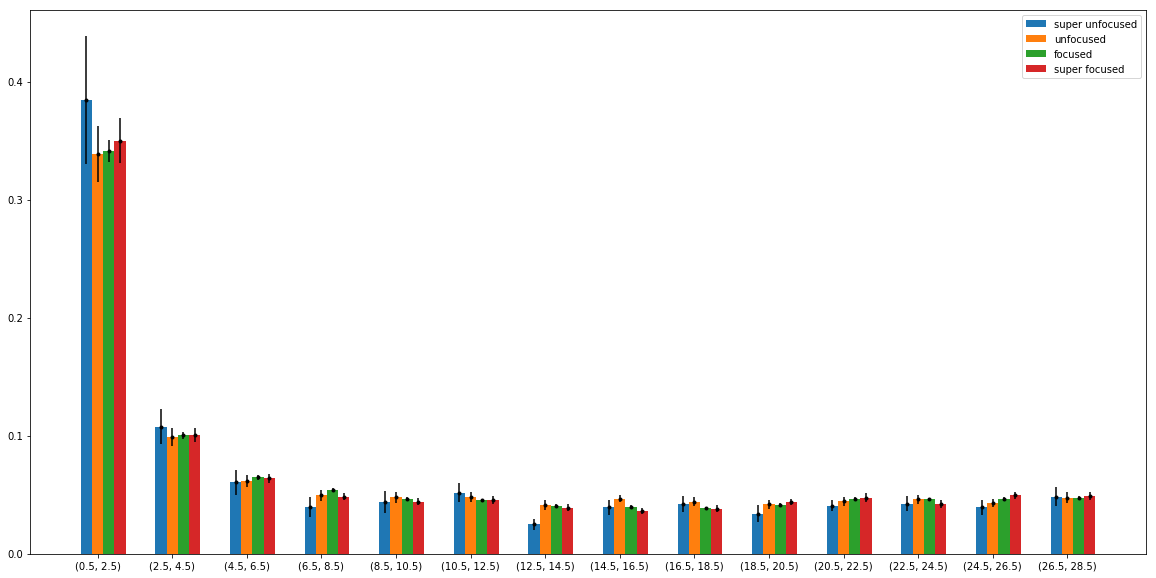

In [35]:
plt.figure(figsize=(20,10))

plotMultipleBarGraphs([super_unfocused_power_ratio_avg, unfocused_power_ratio_avg, focused_power_ratio_avg, super_focused_power_ratio_avg], 0.15, ["super unfocused","unfocused", "focused", "super focused"], intervals, error_values=[super_unfocused_sem, unfocused_sem, focused_sem, super_focused_sem])

## Target x Press analysis (no windowing) 

In [36]:
unfocused_eeg_data, unfocused_averages, unfocused_power_ratio = getLeftRightData(unfocused_data, binning, epoch_length=499, verbose=False)
focused_eeg_data, focused_averages, focused_power_ratio = getLeftRightData(focused_data, binning, epoch_length=499, verbose=False)
mispress_eeg_data, mispress_averages, mispress_power_ratio = getLeftRightData(mispress_data, binning, epoch_length=499, verbose=False)
# neutral_eeg_data, neutral_averages, neutral_power_ratio = getLeftRightData(neutral_data, binning, epoch_length=499, verbose=False)


unfocused_power_ratio_avg = np.mean(unfocused_power_ratio[0] + unfocused_power_ratio[1], axis=0)
focused_power_ratio_avg = np.mean(focused_power_ratio[0] + focused_power_ratio[1], axis=0)

mispress_power_ratio_avg = np.mean(mispress_power_ratio[0] + mispress_power_ratio[1], axis=0)
# neutral_power_ratio_avg = np.mean(neutral_power_ratio[0] + neutral_power_ratio[1], axis=0)

unfocused_sem = getSEM(unfocused_power_ratio[0] + unfocused_power_ratio[1])
focused_sem = getSEM(focused_power_ratio[0] + focused_power_ratio[1])

mispress_sem = getSEM(mispress_power_ratio[0] + mispress_power_ratio[1])
# neutral_sem = getSEM(neutral_power_ratio[0] + neutral_power_ratio[1])

### Frequency Bin analysis

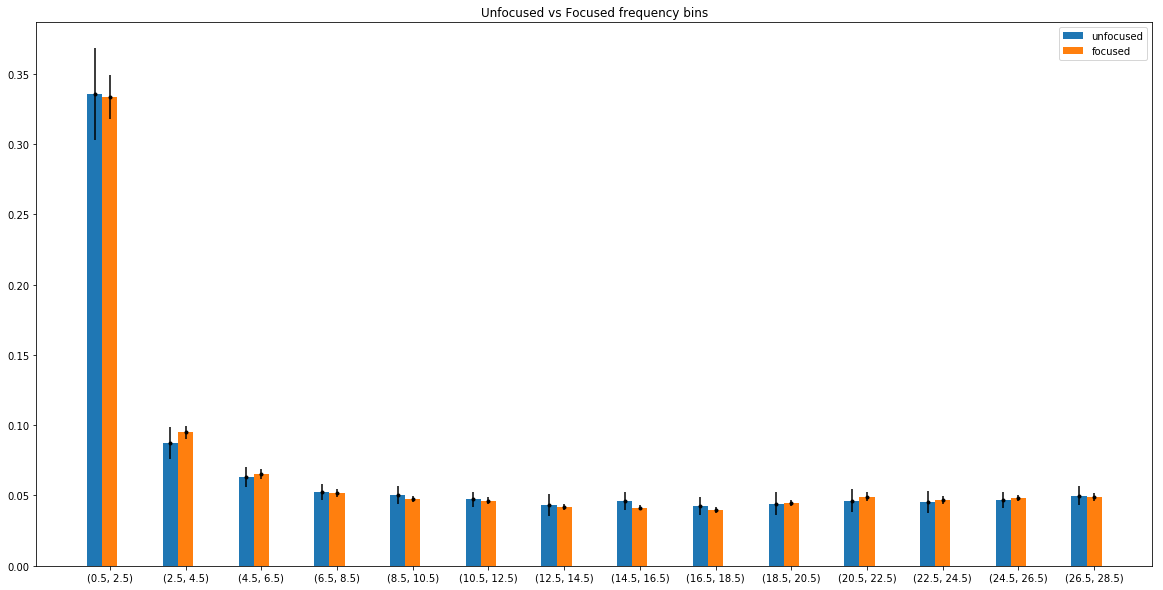

In [37]:
plt.figure(figsize=(20,10))

plt.title("Unfocused vs Focused frequency bins")

plotMultipleBarGraphs([unfocused_power_ratio_avg, focused_power_ratio_avg], 0.2, ["unfocused", "focused"], intervals, error_values=[unfocused_sem, focused_sem])

### ERP analysis

125 375


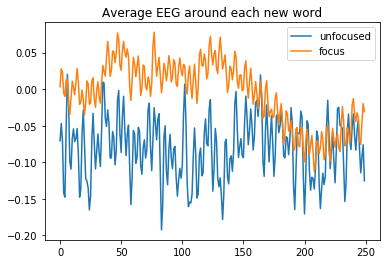

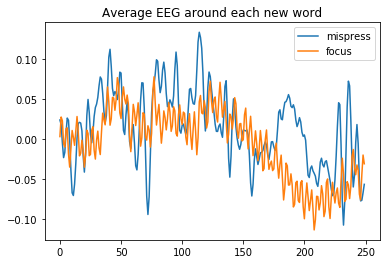

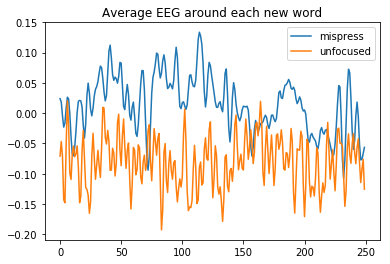

In [38]:
one_sec_start = int(eeg_fs * 0.5)
one_sec_end = int(eeg_fs * 1.5)

print(one_sec_start, one_sec_end)

# Plot ERPs around new word for unfocused vs focus
plt.plot(np.mean(unfocused_eeg_data[0][:] + unfocused_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="unfocused")
plt.plot(np.mean(focused_eeg_data[0][:] + focused_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="focus")
plt.legend()
plt.title("Average EEG around each new word")
plt.show()

# plt.plot(np.mean(neutral_eeg_data[0][:] + neutral_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="neutral")
# plt.plot(np.mean(focused_eeg_data[0][:] + focused_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="focus")
# plt.legend()
# plt.title("Average EEG around each new word")
# plt.show()

plt.plot(np.mean(mispress_eeg_data[0][:] + mispress_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="mispress")
plt.plot(np.mean(focused_eeg_data[0][:] + focused_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="focus")
plt.legend()
plt.title("Average EEG around each new word")
plt.show()

plt.plot(np.mean(mispress_eeg_data[0][:] + mispress_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="mispress")
plt.plot(np.mean(unfocused_eeg_data[0][:] + unfocused_eeg_data[1][:], axis=0)[one_sec_start:one_sec_end], label="unfocused")
plt.legend()
plt.title("Average EEG around each new word")
plt.show()

### Spectral Analysis (no windowing)

In [39]:
unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(unfocused_eeg_data) 
focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(focused_eeg_data) 
mispress_freqs, mispress_psds, mispress_psd_avg = getFreqsAndPSD(mispress_eeg_data) 
# neutral_freqs, neutral_psds, neutral_psd_avg = getFreqsAndPSD(neutral_eeg_data) 



num unfocused 14 num focused 136


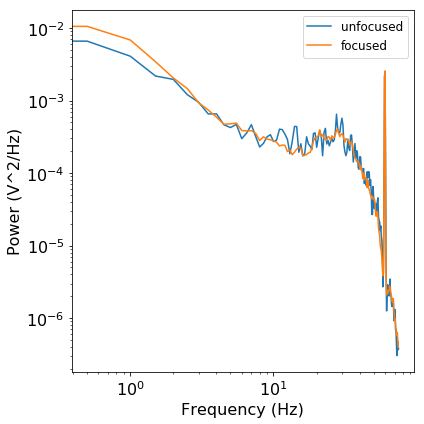

In [40]:
plot_window_size = 150
plot_power_spectra([unfocused_freqs[:plot_window_size], focused_freqs[:plot_window_size]], [unfocused_psd_avg[:plot_window_size] , focused_psd_avg[:plot_window_size]], ["unfocused", "focused"])

print("num unfocused", len(unfocused_psds), "num focused", len(focused_psds))

num mispress 14 num unfocused 14


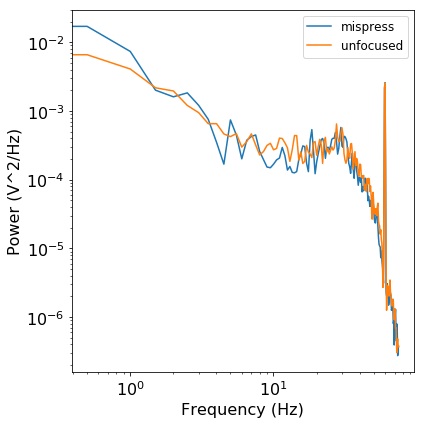

In [41]:
plot_window_size = 150
plot_power_spectra([mispress_freqs[:plot_window_size], unfocused_freqs[:plot_window_size]], [mispress_psd_avg[:plot_window_size] , unfocused_psd_avg[:plot_window_size]], ["mispress", "unfocused"])

print("num mispress", len(mispress_psds), "num unfocused", len(unfocused_psds))

In [42]:
plot_window_size = 150
plot_power_spectra([neutral_freqs[:plot_window_size], focused_freqs[:plot_window_size]], [neutral_psd_avg[:plot_window_size] , focused_psd_avg[:plot_window_size]], ["neutral", "focused"])

print("num neutral", len(neutral_psds), "num focused", len(focused_psds))

NameError: name 'neutral_freqs' is not defined

In [ ]:


# target_word_data, a, t_targ = getTimeBoundSingleLabelData("targetWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
# target_points = [getTotalPoints(data) for data in target_word_data] 

# focused_data = list()
# focused_points = list()
# focused_times = list()
# unfocused_data = list() 
# unfocused_points = list() 
# unfocused_times = list() 

# for i, point in enumerate(target_points) : 
#     if point == 1: 
#         focused_data.append(target_word_data[i])
#         focused_points.append(point)
#         focused_times.append(t_targ[i])
#     else : 
#         unfocused_data.append(target_word_data[i])
#         unfocused_points.append(point)
#         unfocused_times.append(t_targ[i])
        
# print("Focused data:", len(focused_data))
# print("Unfocused data:", len(unfocused_data))

In [43]:
# non_target_word_data, a, t_nontarg = getTimeBoundSingleLabelData("notTargetWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
# non_target_points = [getTotalPoints(data) for data in non_target_word_data] 

# mis_press_data = list() 
# mis_press_points = list()
# mis_press_times = list() 
# neutral_data = list() 
# neutral_points = list() 
# neutral_times = list() 


# for i, point in enumerate(non_target_points) : 
#     if point == -1: 
#         mis_press_data.append(non_target_word_data[i])
#         mis_press_points.append(point)
#         mis_press_times.append(t_nontarg[i])
#     else : 
#         neutral_data.append(non_target_word_data[i])
#         neutral_points.append(point)
#         neutral_times.append(t_nontarg[i])

# print("Mispress data:", len(mis_press_data))
# print("Neutral data:", len(neutral_data))

## Trying to find late presses

In [44]:
num_timepoints = len(filtered_cleaned_data[StreamType.EEG.value][StreamType.TIME.value])

NameError: name 't_targ' is not defined

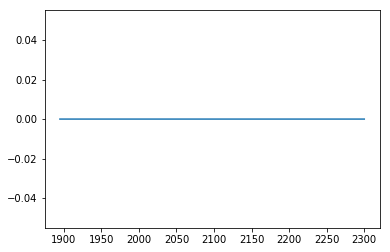

In [45]:
plt.plot(filtered_cleaned_data[StreamType.EEG.value][StreamType.TIME.value], [0]*num_timepoints)
plt.scatter(t_targ, [1]*len(t_targ))
plt.scatter(mis_press_times, [1]*len(mis_press_times))
plt.show()

In [46]:
prevTargetTime = list() # Time of last target word 
for time in mis_press_times: 
    prevTime = 0
    if t_targ[0] < time: 
        prevTime = t_targ[0]
        nextTime = t_targ[1]
        index = 1
        while nextTime < time: 
            index += 1 
            nextTime = t_targ[index] 
            prevTime = t_targ[index-1]
        prevTime = time - prevTime
    prevTargetTime.append(prevTime)

NameError: name 'mis_press_times' is not defined

In [47]:
prevTargetTime

[]

In [ ]:
plt.plot(prevTargetTime)